In [1]:
!pip install transformers datasets evaluate scikit-learn accelerate -q

import pandas as pd
import numpy as np
import torch
import random
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.1 MB/s eta 0:00:00


In [2]:
# 1. Load IMDB Dataset (Kaggle CSV)
df = pd.read_csv("IMDB Dataset.csv")
df = df.rename(columns={"review": "text", "sentiment": "label"})


In [3]:
# Encode labels: pos -> 1, neg -> 0
df['label'] = df['label'].map({'positive': 1, 'negative': 0})

In [4]:
# Train/test split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [5]:
# Convert to HF datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({"train": train_dataset, "test": test_dataset})

In [6]:
# 2. Custom F1 metric function
def compute_f1(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"f1": f1_score(labels, preds)}

In [7]:
# 3. Model list
model_names = [
    "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "microsoft/deberta-v3-base",
    "hf-internal-testing/modernbert-base"
]

# Store results
results = []


In [8]:
# Train small subset for comparison
subset_train = dataset["train"].shuffle(seed=42).select(range(2000))
subset_test = dataset["test"].shuffle(seed=42).select(range(500))

In [13]:
model_names = [
    "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "microsoft/deberta-v3-base"
]

# Store results
results = []

for model_name in model_names:
    print(f"\n===== Training {model_name} on subset =====\n")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess(examples):
        return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

    tokenized_train = subset_train.map(preprocess, batched=True)
    tokenized_test = subset_test.map(preprocess, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    training_args = TrainingArguments(
        output_dir=f"./results/{model_name.replace('/', '_')}",
        eval_strategy="epoch",
        save_strategy="no",
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=1,
        logging_dir="./logs",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        compute_metrics=compute_f1
    )

    trainer.train()
    eval_result = trainer.evaluate()
    results.append((model_name, eval_result["eval_f1"]))


===== Training bert-base-uncased on subset =====



Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-639607171.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.225251,0.919325



===== Training roberta-base on subset =====



Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-639607171.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.198253,0.940520



===== Training distilbert-base-uncased on subset =====



Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-639607171.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.255062,0.898336



===== Training microsoft/deberta-v3-base on subset =====



/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-639607171.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,No log,0.169538,0.937853


In [14]:
# 4. Pick best model
results.sort(key=lambda x: x[1], reverse=True)
best_model_name = results[0][0]
print("\n===== Best model from subset training =====")
print(f"Best Model: {best_model_name} | F1: {results[0][1]:.4f}")

# 5. Fine-tune best model on full dataset
print(f"\n===== Training {best_model_name} on full dataset =====\n")
tokenizer = AutoTokenizer.from_pretrained(best_model_name)


===== Best model from subset training =====
Best Model: roberta-base | F1: 0.9405

===== Training roberta-base on full dataset =====



In [15]:
def preprocess(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_train_full = dataset["train"].map(preprocess, batched=True)
tokenized_test_full = dataset["test"].map(preprocess, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(best_model_name, num_labels=2)


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
training_args = TrainingArguments(
    output_dir="./final_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
    report_to="none"
)

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_full,
    eval_dataset=tokenized_test_full,
    tokenizer=tokenizer,
    compute_metrics=compute_f1
)

trainer.train()
final_eval = trainer.evaluate()
print("\nFinal Model Evaluation:", final_eval)

/tmp/ipython-input-191114164.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.322200,0.372143,0.903274
2,0.228200,0.290959,0.921997



Final Model Evaluation: {'eval_loss': 0.2909592092037201, 'eval_f1': 0.9219971927010226, 'eval_runtime': 151.9796, 'eval_samples_per_second': 65.798, 'eval_steps_per_second': 8.225, 'epoch': 2.0}


In [20]:
# Pick device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Sample 10 random test samples
sampled = test_df.sample(10, random_state=42)

# Tokenize and move inputs to the device
inputs = tokenizer(list(sampled["text"]), truncation=True, padding=True, return_tensors="pt").to(device)

# Move model to the same device
model.to(device)

# Run inference
outputs = model(**inputs)

# Get predictions and move to CPU for numpy conversion
preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

sampled["predicted_sentiment"] = ["positive" if p == 1 else "negative" for p in preds]

print("\n===== Sample Predictions =====")
print(sampled[["text", "label", "predicted_sentiment"]])



===== Sample Predictions =====
                                                    text  label  \
44114  This is loosely based on the ideas of the orig...      0   
38347  This movie was on British TV last night, and i...      1   
32006  What a dreadful movie. The effects were poor, ...      0   
19369  I'll keep this short, as I know I don't need t...      0   
22208  I don't know what the rest of you guys watch S...      0   
9123   Laura Fraser creates her ideal man on a virtua...      0   
15147  Whatever his name is (the writer and director)...      0   
43481  A very interesting documentary - certainly a l...      1   
18677  Fox is pretty lame. They cancel the wrong show...      0   
1111   I saw this movie a fews years ago and was lite...      1   

      predicted_sentiment  
44114            negative  
38347            positive  
32006            negative  
19369            negative  
22208            negative  
9123             negative  
15147            negative  
43481 

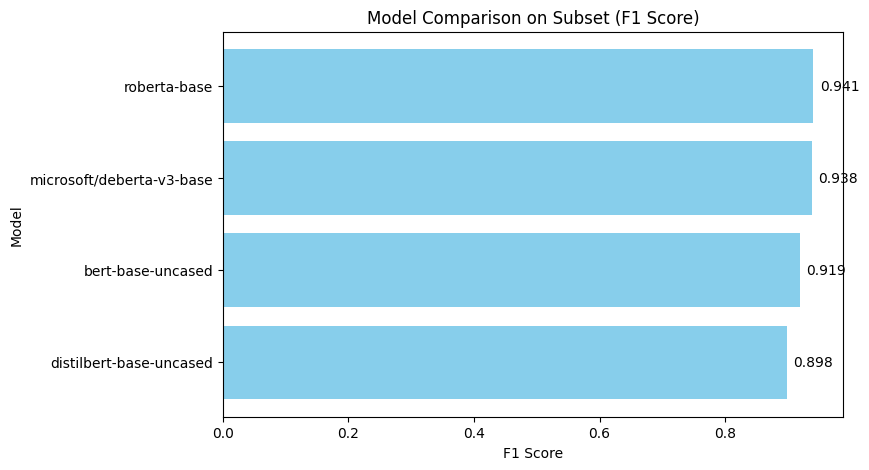

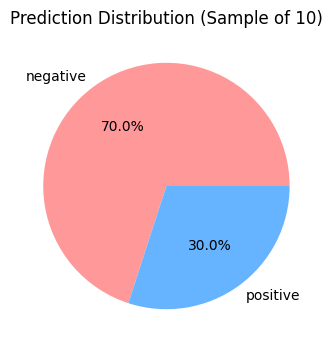

In [21]:
import matplotlib.pyplot as plt

# Visualization: F1 scores of models
model_names_list = [r[0] for r in results]
f1_scores_list = [r[1] for r in results]

plt.figure(figsize=(8, 5))
bars = plt.barh(model_names_list, f1_scores_list, color="skyblue")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.title("Model Comparison on Subset (F1 Score)")
plt.gca().invert_yaxis()  # Best at top
for bar, score in zip(bars, f1_scores_list):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f"{score:.3f}", va='center')
plt.show()

# Visualization: Final model prediction distribution
pred_counts = sampled["predicted_sentiment"].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(pred_counts, labels=pred_counts.index, autopct="%1.1f%%", colors=["#ff9999","#66b3ff"])
plt.title("Prediction Distribution (Sample of 10)")
plt.show()
